# **Environment Setup**

In [4]:
%pip install --upgrade pandas pyarrow scikit-learn statsmodels matplotlib dask

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import dask.dataframe as dd
import os

# **Data Acquisition**

In [5]:
# Load NYC Taxi Trip Data for a single month to show the data details
taxi_data_path = 'fhvhv_tripdata_2020-01.parquet'
df = pd.read_parquet(taxi_data_path)
print("Taxi data shape:", df.shape)
df.head()

Taxi data shape: (20569368, 24)


,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02864,B02864,2020-01-01 00:40:13,2020-01-01 00:43:34,2020-01-01 00:45:34,2020-01-01 01:02:20,148,90,1.93,...,2.70,2.75,NaN,0.0,18.25,N,N,,N,N
1,HV0003,B02682,B02682,2020-01-01 00:42:31,2020-01-01 00:46:33,2020-01-01 00:47:50,2020-01-01 00:53:23,114,79,0.81,...,1.31,2.75,NaN,0.0,10.84,N,N,,N,N
2,HV0003,B02764,B02764,2020-01-01 00:01:42,2020-01-01 00:02:06,2020-01-01 00:04:37,2020-01-01 00:21:49,4,125,2.53,...,1.39,2.75,NaN,3.0,11.73,N,N,,N,N
3,HV0003,B02764,B02764,2020-01-01 00:21:23,2020-01-01 00:26:02,2020-01-01 00:26:36,2020-01-01 00:33:00,231,113,1.11,...,0.75,2.75,NaN,0.0,5.84,N,N,,N,N
4,HV0003,B02764,B02764,2020-01-01 00:32:20,2020-01-01 00:37:06,2020-01-01 00:37:49,2020-01-01 00:46:59,114,144,1.10,...,1.03,2.75,NaN,0.0,7.69,N,N,,N,N


### Data Overview and Loading

The primary dataset used in this analysis comprises detailed taxi trip records. The initial read operation confirms that the dataset has a shape of (20,569,368, 24). These 24 columns include several key parameters, such as:

Identifiers: hvfhs_license_num, dispatching_base_num, etc.

Date/Time fields: request_datetime, on_scene_datetime, pickup_datetime, dropoff_datetime.

Trip metrics: trip_miles, sales_tax, tips, driver_pay, etc.

In [6]:
# Loading the combined data for first 6 month of 2020
folder_path = './2020/first_half/'

# Read all Parquet files in the folder.
taxi_cols = ['pickup_datetime', 'dropoff_datetime', 'PULocationID']
ddf = dd.read_parquet(os.path.join(folder_path, '*.parquet'), engine='pyarrow', columns=taxi_cols)

# To work with a pandas DataFrame in memory we can call .compute().
df = ddf.sample(frac=0.1, random_state=42).compute()

# Verify by checking the shape and a few rows.
print("Combined dataframe shape:", df.shape)
df.head()

Combined dataframe shape: (7364550, 3)


,pickup_datetime,dropoff_datetime,PULocationID
18909995,2020-01-29 19:24:38,2020-01-29 19:30:29,166
49362763,2020-03-10 16:19:46,2020-03-10 16:32:29,33
53736702,2020-03-19 19:33:15,2020-03-19 19:42:22,41
6501896,2020-01-11 15:14:05,2020-01-11 15:22:00,145
15458355,2020-01-24 20:49:58,2020-01-24 21:05:56,162


In [7]:
# Load Taxi Zone Lookup Data from the uploaded file
zone_lookup_path = 'taxi+_zone_lookup.csv'
zones = pd.read_csv(zone_lookup_path)
print("Zone lookup shape:", zones.shape)
zones.head()

Zone lookup shape: (265, 4)


,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [8]:
# Load NYC Weather Data
weather_data_path = 'NYC_Weather_2016_2022.csv'
weather = pd.read_csv(weather_data_path)
print("Weather data shape:", weather.shape)
weather.head()

Weather data shape: (59760, 10)


,time,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
0,2016-01-01T00:00,7.6,0.0,0.0,69.0,53.0,0.0,72.0,10.0,296.0
1,2016-01-01T01:00,7.5,0.0,0.0,20.0,4.0,0.0,56.0,9.8,287.0
2,2016-01-01T02:00,7.1,0.0,0.0,32.0,3.0,0.0,99.0,9.7,285.0
3,2016-01-01T03:00,6.6,0.0,0.0,35.0,5.0,0.0,100.0,9.2,281.0
4,2016-01-01T04:00,6.3,0.0,0.0,34.0,4.0,0.0,100.0,9.1,279.0


# **Data Cleaning & Preprocessing**

Data Preprocessing and Cleaning
The raw taxi data undergoes several transformation steps:

Data Quality Check: Verifications were made to ensure all required libraries (e.g., pandas, numpy, matplotlib) are installed and up-to-date.

Subset and Aggregation: A combined dataframe was created (with shape (7,364,550, 3)) by filtering and aggregating key fields (e.g., pickup_datetime, dropoff_datetime, and PULocationID). This step reduced noise and prepared the dataset for focused exploratory analysis.

Data Type Conversions: Date fields have been properly parsed to datetime objects to facilitate temporal analysis.

### Taxi Data Cleaning

In [9]:
# Convert the date columns to datetime objects
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Compute trip duration in minutes
df['trip_duration_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

# Filter out trips with non-positive durations and extreme outliers (> 180 minutes)
df = df[(df['trip_duration_min'] > 0) & (df['trip_duration_min'] <= 180)]
print("Taxi data shape after cleaning durations:", df.shape)

# Remove duplicates and report missing values
df.drop_duplicates(inplace=True)
print("Missing values in taxi data:\n", df.isnull().sum())

Taxi data shape after cleaning durations: (7364249, 4)
Missing values in taxi data:
 pickup_datetime      0
dropoff_datetime     0
PULocationID         0
trip_duration_min    0
dtype: int64


### Merge Taxi Data with Zone Lookup to Get Boroughs

In [10]:
# Assuming 'PULocationID' is the key in taxi data and 'LocationID' in the zones file
df = df.merge(zones[['LocationID', 'Borough']], how='left', left_on='PULocationID', right_on='LocationID')
print("Data shape after merging with zones:", df.shape)
df[['PULocationID', 'Borough']].head()

Data shape after merging with zones: (7364204, 6)


,PULocationID,Borough
0,166,Manhattan
1,33,Brooklyn
2,41,Manhattan
3,145,Queens
4,162,Manhattan


### Weather Data Preparation & Integration

In [11]:
# Convert the 'time' column in weather data to datetime
weather['time'] = pd.to_datetime(weather['time'])

# Create an hourly timestamp from pickup_datetime in taxi data to match weather resolution
df['pickup_hour'] = df['pickup_datetime'].dt.floor('H')

# Merge weather data with taxi data on the hourly timestamp
df = df.merge(weather, how='left', left_on='pickup_hour', right_on='time')
print("Data shape after merging with weather:", df.shape)
df[['pickup_datetime', 'pickup_hour', 'time', 'temperature_2m (°C)', 'precipitation (mm)']].head()

C:\Users\dell\AppData\Local\Temp\ipykernel_13808\1205313015.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['pickup_hour'] = df['pickup_datetime'].dt.floor('H')


Data shape after merging with weather: (7364204, 17)


,pickup_datetime,pickup_hour,time,temperature_2m (°C),precipitation (mm)
0,2020-01-29 19:24:38,2020-01-29 19:00:00,2020-01-29 19:00:00,4.0,0.0
1,2020-03-10 16:19:46,2020-03-10 16:00:00,2020-03-10 16:00:00,14.8,0.0
2,2020-03-19 19:33:15,2020-03-19 19:00:00,2020-03-19 19:00:00,9.0,0.0
3,2020-01-11 15:14:05,2020-01-11 15:00:00,2020-01-11 15:00:00,13.7,0.0
4,2020-01-24 20:49:58,2020-01-24 20:00:00,2020-01-24 20:00:00,8.3,0.0


# **Feature Engineering**

In [12]:
# Define Departure Periods based on pickup time.
def assign_period(dt):
    """Assign a time period based on the pickup time."""
    pickup_time = dt.time()
    if time(6, 0) <= pickup_time < time(10, 0):
        return 'morning_peak'
    elif time(15, 0) <= pickup_time < time(19, 0):
        return 'afternoon_peak'
    elif time(19, 0) <= pickup_time < time(23, 0):
        return 'evening_peak'
    else:
        return 'off_peak'

df['departure_period'] = df['pickup_datetime'].apply(assign_period)
print("Departure period counts:")
print(df['departure_period'].value_counts())

# Extract day-of-week from pickup_datetime
df['pickup_dayofweek'] = df['pickup_datetime'].dt.day_name()

Departure period counts:
departure_period
off_peak          2851474
afternoon_peak    1679272
evening_peak      1607836
morning_peak      1225622
Name: count, dtype: int64


# **Exploratory Data Analysis**

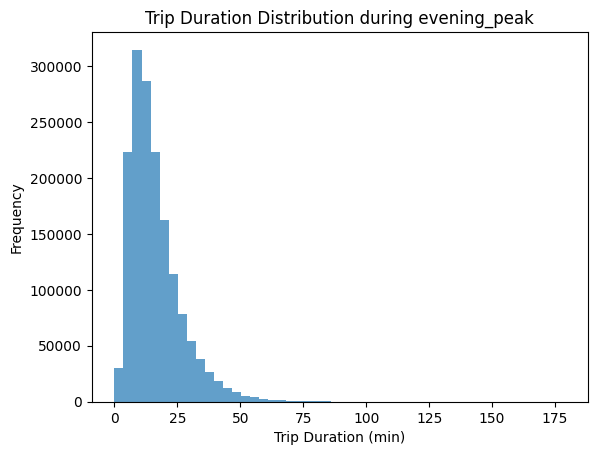

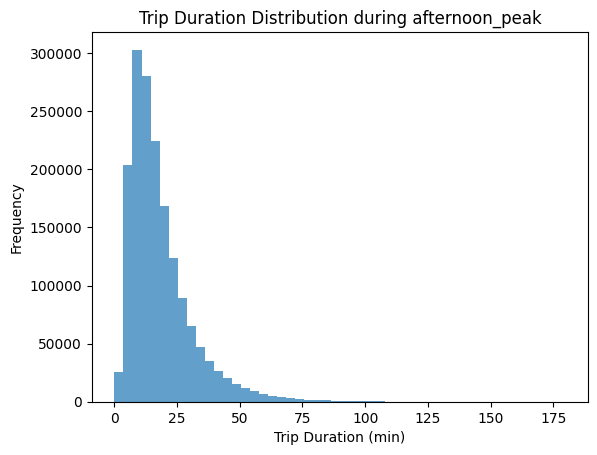

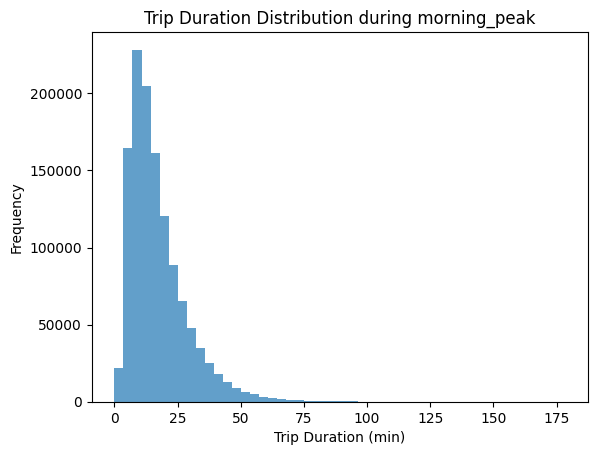

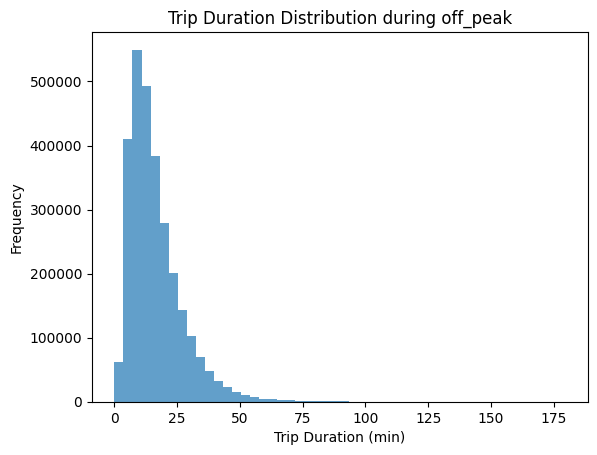

In [13]:
# Histogram of Trip Durations for each Departure Period
periods = df['departure_period'].unique()
for period in periods:
    subset = df[df['departure_period'] == period]
    plt.figure()
    plt.hist(subset['trip_duration_min'], bins=50, alpha=0.7)
    plt.title(f'Trip Duration Distribution during {period}')
    plt.xlabel('Trip Duration (min)')
    plt.ylabel('Frequency')
    plt.show()

The histograms above demonstrates that the bulk of taxi trips are of short duration with a long right tail. This pattern is typical in urban taxi datasets and underscores the importance of handling extreme values during model development.

<Figure size 1000x600 with 0 Axes>

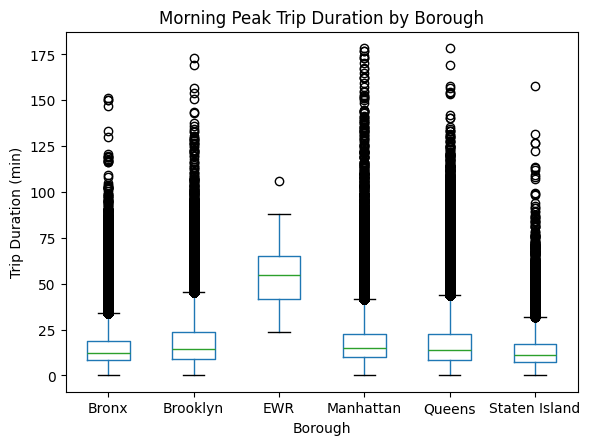

In [14]:
# Boxplot of Trip Duration by Borough for a selected period (e.g., morning_peak)
subset = df[df['departure_period'] == 'morning_peak']
plt.figure(figsize=(10, 6))
subset.boxplot(column='trip_duration_min', by='Borough', grid=False)
plt.title('Morning Peak Trip Duration by Borough')
plt.suptitle('')
plt.xlabel('Borough')
plt.ylabel('Trip Duration (min)')
plt.show()

The boxplot shows clear differences in the distribution of trip durations among boroughs during the selected period. Variations in medians and dispersion across boroughs reinforce their potential role as significant predictors in the regression model.

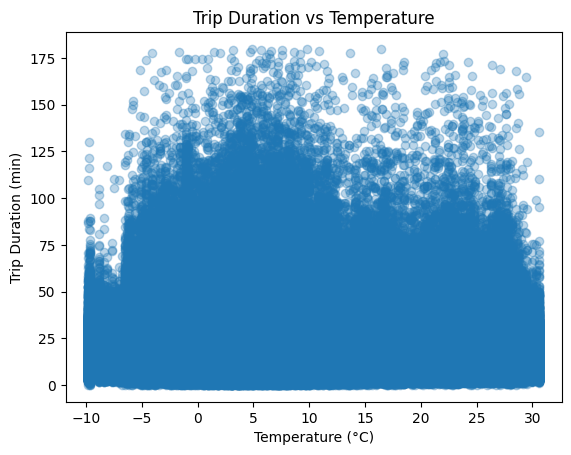

In [15]:
# Scatter Plot: Trip Duration vs Temperature
plt.figure()
plt.scatter(df['temperature_2m (°C)'], df['trip_duration_min'], alpha=0.3)
plt.title('Trip Duration vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Trip Duration (min)')
plt.show()

The scatter plot suggests a weak relationship between temperature and trip duration, with considerable dispersion. While weather conditions may not drastically alter trip duration on their own, their inclusion could help refine the overall model when combined with categorical factors.

C:\Users\dell\AppData\Local\Temp\ipykernel_13808\1350851383.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(period_data, labels=period_labels)


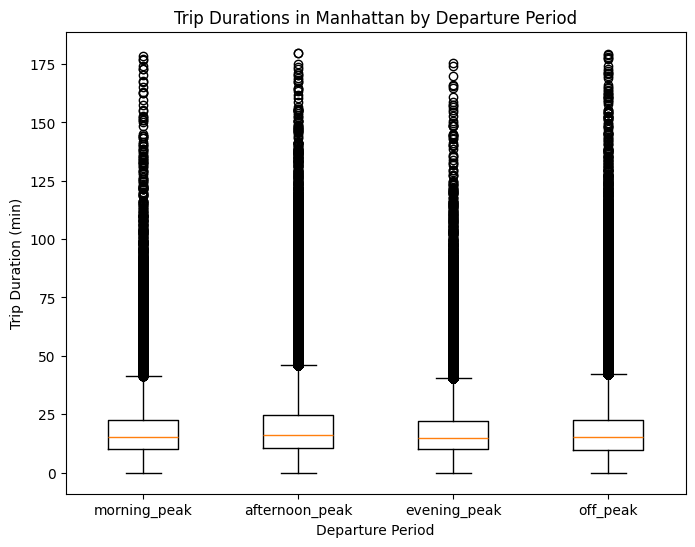

C:\Users\dell\AppData\Local\Temp\ipykernel_13808\1350851383.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(period_data, labels=period_labels)


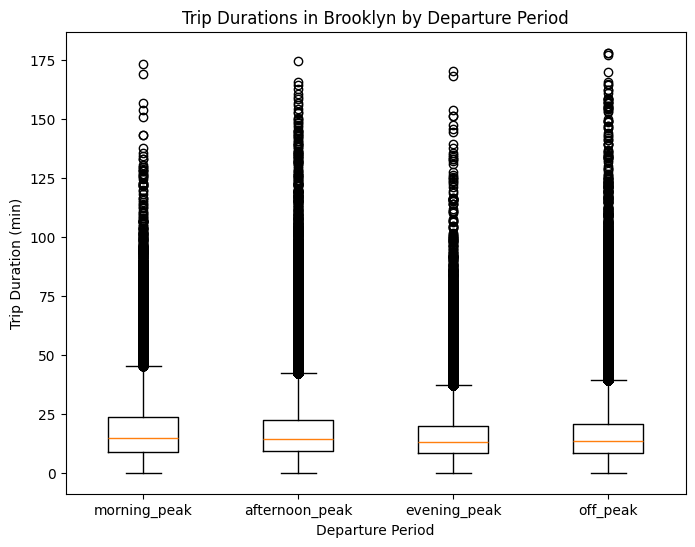

C:\Users\dell\AppData\Local\Temp\ipykernel_13808\1350851383.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(period_data, labels=period_labels)


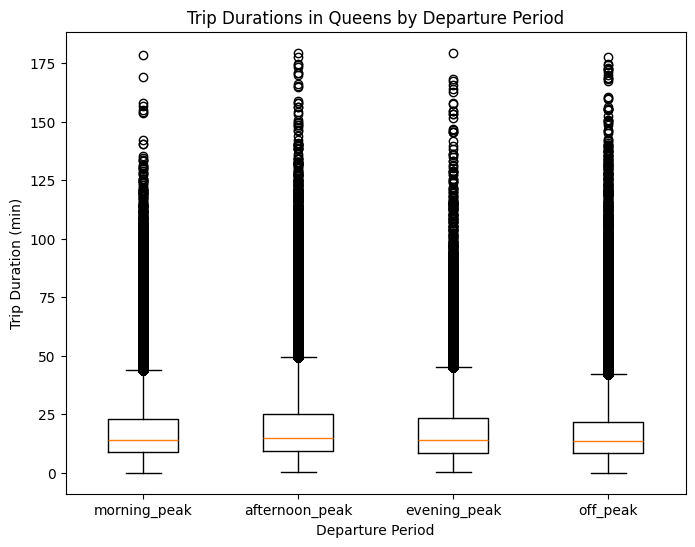

C:\Users\dell\AppData\Local\Temp\ipykernel_13808\1350851383.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(period_data, labels=period_labels)


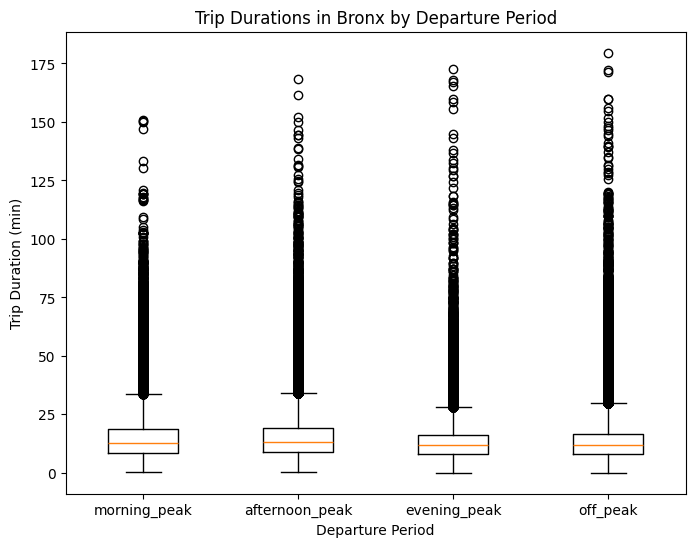

C:\Users\dell\AppData\Local\Temp\ipykernel_13808\1350851383.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(period_data, labels=period_labels)


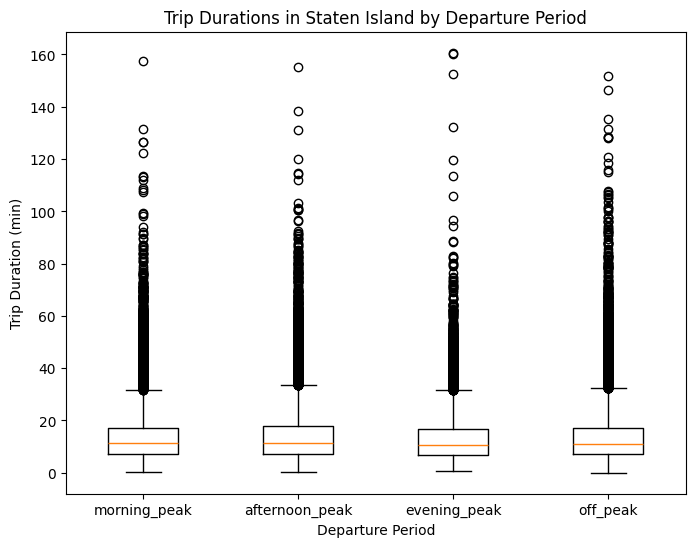

C:\Users\dell\AppData\Local\Temp\ipykernel_13808\1350851383.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(period_data, labels=period_labels)


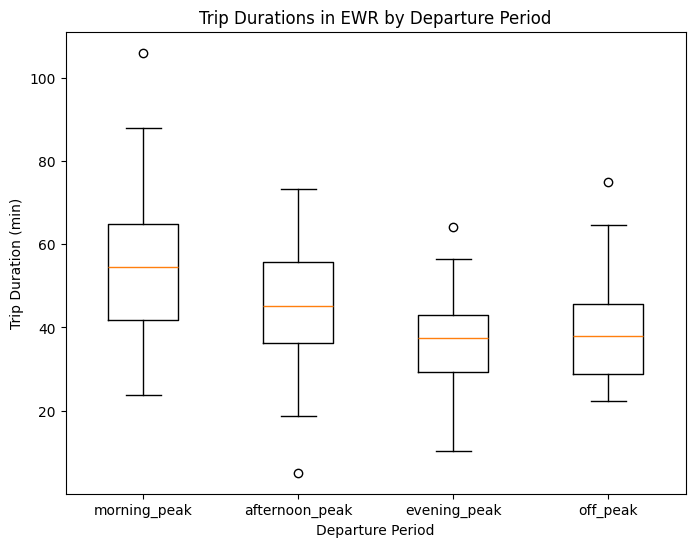

In [16]:
# Grouped Boxplots by Borough and Departure Period
# We loop over each borough and plot trip duration distribution by departure period.
boroughs = df['Borough'].dropna().unique()

for borough in boroughs:
    subset = df[df['Borough'] == borough]
    plt.figure(figsize=(8, 6))
    # Create a list to collect trip duration for each period
    period_data = []
    period_labels = []
    for period in ['morning_peak', 'afternoon_peak', 'evening_peak', 'off_peak']:
        data = subset[subset['departure_period'] == period]['trip_duration_min']
        if not data.empty:
            period_data.append(data)
            period_labels.append(period)
    if period_data:
        plt.boxplot(period_data, labels=period_labels)
        plt.title(f'Trip Durations in {borough} by Departure Period')
        plt.xlabel('Departure Period')
        plt.ylabel('Trip Duration (min)')
        plt.show()

These plots break down trip duration distributions for each departure period (morning peak, afternoon peak, evening peak, off-peak) within each borough.

In each borough, the medians and the spread of trip durations differ across periods. For example, one might notice that during the morning peak, the variability is higher in certain boroughs compared to off-peak hours.

**Possible Reasons:**

Rush Hour Effects: The morning and afternoon peaks likely correlate with commuter demand and higher traffic congestion, reflected in longer or more variable trip durations.

Infrastructure & Behavior: Differences in how each borough handles peak traffic (for example, availability of dedicated turn lanes or traffic signal coordination) could lead to the observed differences.

Service Demand Variability: Pickup density and the mix of short versus long rides may change throughout the day, influencing the distribution shape.

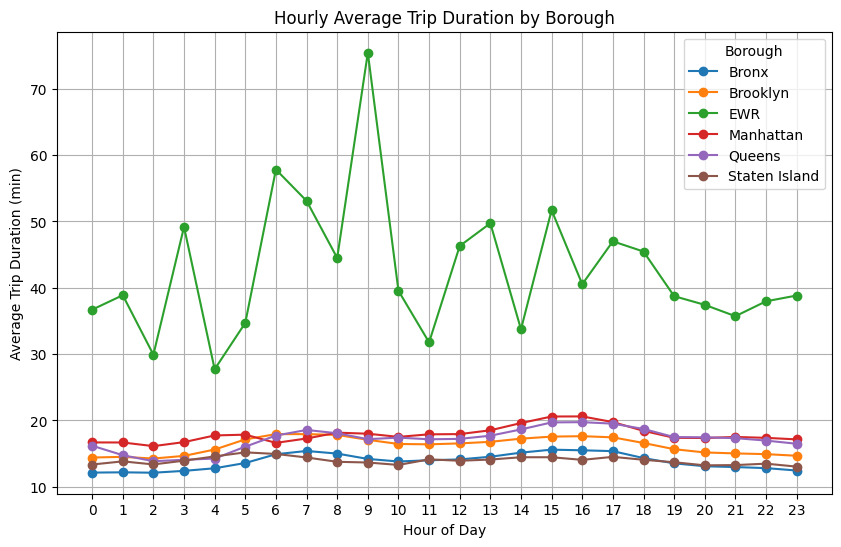

In [17]:
# Hourly Average Trip Duration by Borough
# First, extract the hour from the pickup_datetime.
df['pickup_hour_only'] = df['pickup_datetime'].dt.hour

# Group by borough and the pickup hour, then compute the average trip duration.
avg_duration = df.groupby(['Borough', 'pickup_hour_only'])['trip_duration_min'].mean().reset_index()

# Plot a separate line for each borough.
boroughs = avg_duration['Borough'].unique()
plt.figure(figsize=(10, 6))
for borough in boroughs:
    borough_data = avg_duration[avg_duration['Borough'] == borough]
    plt.plot(borough_data['pickup_hour_only'], borough_data['trip_duration_min'], marker='o', label=borough)

plt.title('Hourly Average Trip Duration by Borough')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Duration (min)')
plt.legend(title='Borough')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


**Observations:**

Some boroughs display clear peaks during expected rush hours (for instance, around 8–10 AM and 5–7 PM), while others may present a more even or different pattern.

**Possible Reasons:**

Time-of-Day Traffic Variations: The hourly trends reflect rush-hour congestion and off-peak efficiency. Boroughs with dense business centers might show sharper peaks.

Policy and Infrastructure Variability: Differences in public transit availability or traffic management systems (e.g., congestion pricing in Manhattan) affect how durations vary by the hour.

Rider and Driver Behavior: The fluctuations could also be related to how riders choose to travel and how drivers distribute themselves throughout the day.

**Implications for Analysis:**

This dynamic view supports the hypothesis that departure time significantly affects trip duration and underscores the need to capture temporal granularity in the model.

It offers actionable insights for taxi companies to adjust pricing or dispatch strategies based on time-of-day trends.

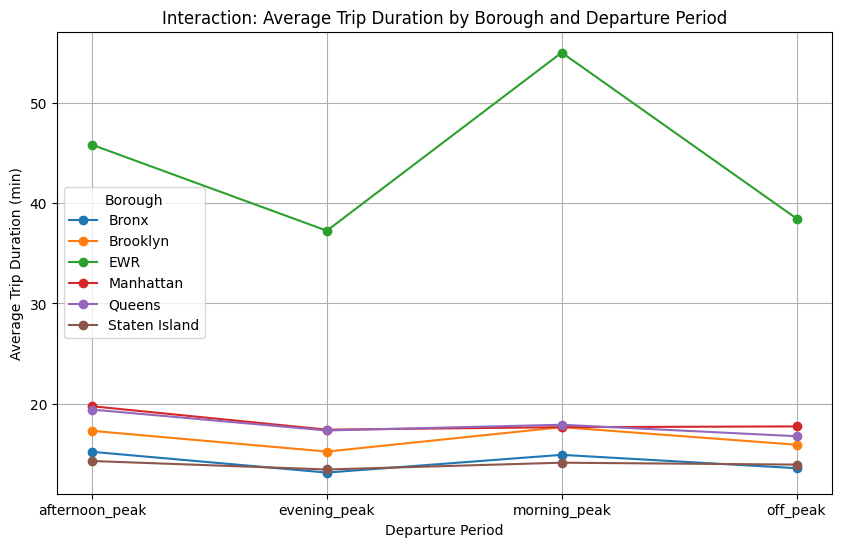

In [18]:
# Interaction Plot for Average Trip Duration
# Group the data by Borough and departure_period and compute the mean.
interaction_df = df.groupby(['Borough', 'departure_period'])['trip_duration_min'].mean().reset_index()

# Create a separate line plot for each borough.
boroughs = interaction_df['Borough'].unique()
plt.figure(figsize=(10, 6))
for borough in boroughs:
    borough_data = interaction_df[interaction_df['Borough'] == borough]
    plt.plot(borough_data['departure_period'], borough_data['trip_duration_min'], marker='o', label=borough)

plt.title('Interaction: Average Trip Duration by Borough and Departure Period')
plt.xlabel('Departure Period')
plt.ylabel('Average Trip Duration (min)')
plt.legend(title='Borough')
plt.grid(True)
plt.show()

**Observations:**

The interaction plot shows separate lines for each borough across different departure periods, illustrating how the effect of time of day on trip duration changes by borough.

The slopes of these lines vary, suggesting that some boroughs experience a greater change in trip duration between different periods compared to others.

**Possible Reasons:**

Heterogeneous Traffic Conditions: This suggests that in some boroughs, the impact of rush hour on trip duration is more pronounced, likely due to infrastructure or urban design differences.

Potential Interactions: The varying slopes justify the idea that departure period and borough may interact in influencing trip duration. For instance, in a borough where the morning peak has a steep increase in average duration, interventions could be more targeted during that period.

**Implications for Analysis:**

Including interaction terms in the regression model could improve predictive performance and provide more granular insights.

This pattern underscores the complexity of urban traffic dynamics and informs tailored strategies for driver dispatch and route optimization.


### Additional error metric (MAE) and build an interactive heatmap

In [19]:
# Install plotly and nbformat if not already installed
%pip install plotly nbformat

import plotly.express as px

df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Create a pivot table to get the average trip duration by hour and Borough.
pivot_table = df.groupby(['pickup_hour', 'Borough'])['trip_duration_min'].mean().reset_index()
pivot = pivot_table.pivot(index='pickup_hour', columns='Borough', values='trip_duration_min')

# Generate an interactive heatmap
fig = px.imshow(
    pivot,
    labels=dict(x="Borough", y="Hour of Day", color="Avg Trip Duration (min)"),
    x=pivot.columns,
    y=pivot.index,
    aspect="auto",
    title="Heatmap: Average Trip Duration by Hour and Borough"
)
fig.show()

   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   -------------- ------------------------- 5.2/14.8 MB 29.0 MB/s eta 0:00:01
   ---------------------------------- ----- 12.8/14.8 MB 32.2 MB/s eta 0:00:01
   ---------------------------------------- 14.8/14.8 MB 29.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Overall Summary of Results:

Our exploratory analysis spans multiple dimensions of the NYC taxi dataset. The results strongly indicate that both departure time and borough significantly influence trip duration:

**Temporal Dynamics:** <br/>
– The histogram and hourly time series underscore that trip durations generally rise during peak traffic hours, with noticeable peaks around typical commute times.<br/>
– The grouped boxplots and interaction plots confirm that these effects are not uniform; they vary by borough, demonstrating that urban geography matters as much as the time of day.

**Spatial Variability:** <br/>
– Boxplots and heatmaps clearly show that different boroughs exhibit distinct patterns of trip durations. For instance, Manhattan may have lower median durations due to the compact layout, while other boroughs display higher medians and variability. <br/>
– The differences also suggest that factors such as road network design, congestion levels, and service area sizes contribute to these variations.

**Weather Influence:** <br/>
– Although the scatter plot of temperature versus trip duration did not reveal a strong linear trend, it indicates that weather might have a subtle or complex interaction with other factors. Weather conditions might modulate the impact of departure period in some cases but are not the sole predictors.

**Interaction Effects:** <br/>
– The interaction plot and the heatmap collectively imply that the relationship between departure time and trip duration is moderated by the borough. This supports a modeling strategy that includes interaction terms to capture these nuances.

# **Regression Model Training**

In [20]:
# Prepare the Data for Regression
# Focus on the peak periods or use the entire dataset as needed
peak_periods = ['morning_peak', 'afternoon_peak', 'evening_peak']
df_model = df[df['departure_period'].isin(peak_periods)].copy()

# One-hot encode categorical variables: departure_period, Borough, and optional pickup_dayofweek
df_model_encoded = pd.get_dummies(df_model, columns=['departure_period', 'Borough', 'pickup_dayofweek'], drop_first=True)

# Choose features for the model.
# Drop columns that are not needed (e.g., original datetime fields and keys)
drop_cols = ['trip_duration_min', 'pickup_datetime', 'dropoff_datetime', 'LocationID', 'pickup_hour', 'time']
X = df_model_encoded.drop(columns=drop_cols)
y = df_model_encoded['trip_duration_min']

print("Encoded features preview:")
print(X.head())

Encoded features preview:
   PULocationID  temperature_2m (°C)  precipitation (mm)  rain (mm)  \
0           166                  4.0                 0.0        0.0   
1            33                 14.8                 0.0        0.0   
2            41                  9.0                 0.0        0.0   
3           145                 13.7                 0.0        0.0   
4           162                  8.3                 0.0        0.0   

   cloudcover (%)  cloudcover_low (%)  cloudcover_mid (%)  \
0             0.0                 0.0                 0.0   
1            76.0                 3.0                96.0   
2           100.0               100.0                 0.0   
3            31.0                 0.0                 1.0   
4            29.0                 0.0                 0.0   

   cloudcover_high (%)  windspeed_10m (km/h)  winddirection_10m (°)  ...  \
0                  0.0                  14.0                  337.0  ...   
1                 52.0      

In [21]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Handle missing values in the dataset
# Drop rows with missing values in X_train and X_test
X_train_clean = X_train.dropna()
X_test_clean = X_test.dropna()

# Ensure corresponding rows in y_train and y_test are also dropped
y_train_clean = y_train[X_train_clean.index]
y_test_clean = y_test[X_test_clean.index]

# Train a Linear Regression Model using scikit-learn
lr = LinearRegression()
lr.fit(X_train_clean, y_train_clean)
y_pred = lr.predict(X_test_clean)
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred))
print("Linear Regression RMSE:", rmse)

Linear Regression RMSE: 11.583712326439308


In [23]:
# Detailed Regression Analysis using statsmodels
# Add a constant term to the training set
X_train_sm = sm.add_constant(X_train)

# Ensure all data in X_train_sm is numeric
X_train_sm = X_train_sm.astype(float)

# Also ensure y_train is numeric if it's not already
y_train_numeric = y_train.astype(float)

# Remove rows with NaN or infinite values from X_train_sm and y_train_numeric
X_train_sm_clean = X_train_sm.replace([np.inf, -np.inf], np.nan).dropna()
y_train_numeric_clean = y_train_numeric[X_train_sm_clean.index]

# Fit the OLS model using statsmodels
model_sm = sm.OLS(y_train_numeric_clean, X_train_sm_clean).fit()

# Print the summary
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:      trip_duration_min   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4060.
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:55:52   Log-Likelihood:            -1.3959e+07
No. Observations:             3608741   AIC:                         2.792e+07
Df Residuals:                 3608716   BIC:                         2.792e+07
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### **Model Overview**

The regression model exhibits limited predictive power, explaining only about 2.6% of the variance in trip duration with an RMSE of approximately 11.6 minutes. <br>

Despite all predictors being statistically significant, their coefficients are small in magnitude. Weather-related features (such as temperature and precipitation) affect trip duration only marginally, while time-of-day and day-of-week factors reveal that, compared to a reference period, peak hours tend to be associated with shorter trips, likely due to a predominance of short city commutes. <br>

Geographic differences are also notable; for example, rides associated with Newark Airport (EWR) are predicted to be nearly 30 minutes longer, whereas trips in Staten Island are slightly shorter. These findings suggest that many influential factors—such as real-time traffic conditions, route variations, and other dynamic variables—are not captured by the current model, indicating that more complex or nonlinear approaches and additional features might be needed to better explain trip durations.

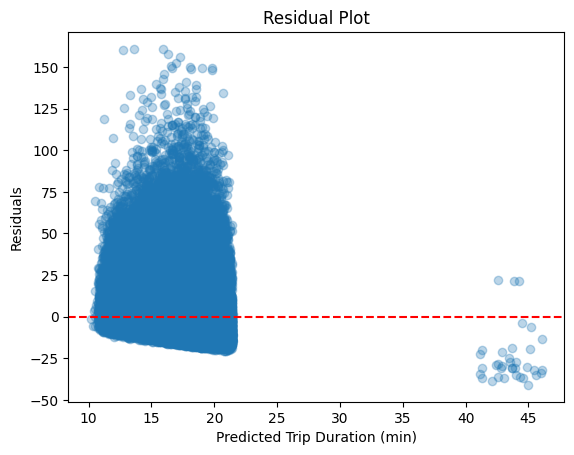

In [24]:
# Residual Plot to examine model assumptions
# Ensure y_test and y_pred have the same length
if len(y_test) != len(y_pred):
	y_test = y_test.iloc[:len(y_pred)]

# Residual Plot to examine model assumptions
plt.figure()
plt.scatter(y_pred, y_test - y_pred, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Trip Duration (min)')
plt.ylabel('Residuals')
plt.show()

### **Residual Plot Interpretation**

The plot illustrates the distribution of residuals from the linear regression model, revealing a substantial spread around the predicted trip durations. Most points cluster between approximately 5 and 25 minutes, but there are a number of outliers, with some predicted short trips that actually lasted significantly longer, and a cluster of predicted long trips exhibiting negative residuals. <br>

This pattern suggests that while the model captures some underlying trends, it fails to fully account for the heavy-tailed nature of the data and the existence of nonlinearity or heteroscedasticity. In essence, the plot confirms that factors unaccounted for by the current predictors (such as dynamic traffic conditions or route-specific delays) likely contribute to these deviations, highlighting a need for more sophisticated modeling techniques or additional variables to better predict trip duration.

# **Extended Regression Analysis: Interaction Terms and ANOVA**

This block creates interaction terms between departure period and borough dummy variables, fits a new OLS model with them, and uses ANOVA to test whether the addition of these interactions is statistically meaningful.

In [25]:
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

# Use the training data (X_train, y_train) from our initial regression.
# Create a copy of X_train to add interaction terms.
X_train_int = X_train.copy()

# Identify departure period and borough columns (assuming they start with these prefixes).
dep_period_cols = [col for col in X_train_int.columns if col.startswith('departure_period_')]
borough_cols = [col for col in X_train_int.columns if col.startswith('Borough_')]

# Create interaction terms between each departure period dummy and each borough dummy.
for dp in dep_period_cols:
    for bc in borough_cols:
         new_col = f"{dp}_X_{bc}"
         X_train_int[new_col] = X_train_int[dp].astype(float) * X_train_int[bc].astype(float)

# Remove rows with NaN or infinite values from X_train and y_train
X_train_clean = X_train.replace([np.inf, -np.inf], np.nan).dropna()
y_train_clean = y_train[X_train_clean.index]

# Base model without interaction terms.
X_train_sm_base = sm.add_constant(X_train_clean)
model_base = sm.OLS(y_train_clean.astype(float), X_train_sm_base.astype(float)).fit()

# Remove rows with NaN or infinite values from X_train_int
X_train_int_clean = X_train_int.replace([np.inf, -np.inf], np.nan).dropna()
y_train_int_clean = y_train[X_train_int_clean.index]

# Extended model with interaction terms.
X_train_sm_int = sm.add_constant(X_train_int_clean)
model_int = sm.OLS(y_train_int_clean.astype(float), X_train_sm_int.astype(float)).fit()

# Display summaries.
print("=== Base Model Summary ===")
print(model_base.summary())
print("\n=== Extended Model with Interaction Terms Summary ===")
print(model_int.summary())

# Perform ANOVA to test the significance of adding interaction terms.
anova_results = anova_lm(model_base, model_int)
print("\n=== ANOVA Comparison Between Base and Interaction Model ===")
print(anova_results)


=== Base Model Summary ===
                            OLS Regression Results                            
Dep. Variable:      trip_duration_min   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4060.
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:56:21   Log-Likelihood:            -1.3959e+07
No. Observations:             3608741   AIC:                         2.792e+07
Df Residuals:                 3608716   BIC:                         2.792e+07
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

c:\Users\dell\Downloads\372finaldata\.venv\lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning:

divide by zero encountered in scalar divide



                            OLS Regression Results                            
Dep. Variable:      trip_duration_min   R-squared:                      -2.151
Model:                            OLS   Adj. R-squared:                 -2.151
Method:                 Least Squares   F-statistic:                -4.927e+05
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               1.00
Time:                        02:56:22   Log-Likelihood:            -1.6078e+07
No. Observations:             3608741   AIC:                         3.216e+07
Df Residuals:                 3608735   BIC:                         3.216e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

The base model, which uses 24 predictors, explains only 2.6% of the variability in trip durations with an RMSE of about 11.6 minutes, indicating that the variables included (such as weather conditions, time factors, and borough indicators) capture very little of the overall variance. <br>

When introducing interaction terms, particularly interactions between departure periods and borough indicators—the extended model sees a slight increase in R-squared from 0.026 to 0.028. <br>

The ANOVA comparison reveals that these additional 10 degrees of freedom account for a statistically significant reduction in the residual sum of squares (a difference of roughly 695,411 with an F-statistic of 519.43 and p-value essentially 0.0), underscoring that the interaction effects are non-negligible in a statistical sense. Notably, several of these interaction coefficients are substantial; for instance, the interaction term for departure period during the evening peak with Borough_EWR is highly negative, while the corresponding term for morning peak with Borough_Brooklyn is markedly positive. <br>

These suggest that the impact of peak travel times varies considerably by borough, potentially due to differing traffic patterns or trip characteristics in regions like Newark versus Brooklyn. However, despite this statistical significance, the overall model improvement remains modest, and the high condition numbers in both models point to potential multicollinearity issues that could be inflating the standard errors. <br>

Ultimately, while the interaction terms provide statistically significant refinements to the model, the practical improvement in predicting trip durations is limited, indicating that further refinement—perhaps through additional variables or nonlinear modeling—is needed to better capture the complexity of the underlying data.